In [1]:
from coffea import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
plt.style.use(hep.style.CMS)

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm()}

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/chloeg/Desktop/Work/Fermilab2021/HistData/kshort_pn_4GeV_May10_ntuple/*.root")

In [3]:
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)
    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

def get_vector(arr,br=['px','py','pz','e'],name="LV"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)
    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part

def mass(self):
     #   r"""Invariant mass (+, -, -, -)
      #  :math:`\sqrt{t^2-x^2-y^2-z^2}`
      #  """
        return numpy.sqrt(self.mass2)
    
def absolute(self):
      #  """Magnitude of this Lorentz vector
     #   Alias for `mass`
       # """
        return self.mass
    
def flat(x,axis=None):
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

In [4]:
hists = {}
hists["Target_mass_hist"] = hist.Hist("Target SP Kaons",
                                hist.Cat("Ptype", "Type of Particle"),         
                                hist.Bin("m", r"Mass", 80, 139.568, 139.572),
                            )        

In [5]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)

    target_kaon_dau1 = ldmx_events['Target_Kaon_dau1']
    target_kaon_dau2 = ldmx_events['Target_Kaon_dau2']
    
    masks_id = {'Pionpm': 211,
               }

    for part,pmask in masks_id.items():
        part_mask1p = (abs(target_kaon_dau1.pdgID)==pmask)
        part_mask2p = (abs(target_kaon_dau2.pdgID)==pmask)
        part_mask1k = (abs(target_kaon_dau1.mompdgID)== 310)
        part_mask2k = (abs(target_kaon_dau2.mompdgID)== 310)
        
        target_kaon_dau1a = get_vector(target_kaon_dau1[part_mask1p & part_mask1k])
        target_kaon_dau2a = get_vector(target_kaon_dau2[part_mask2p & part_mask2k])
    
        mass_data1 = flat(target_kaon_dau1a.mass)
        mass_data2 = flat(target_kaon_dau2a.mass)
        mass_data = np.append(mass_data1, mass_data2)
        print(mass_data)
    
        hists["Target_mass_hist"].fill(Ptype=part,      
                                 m=mass_data,      
                                )

In [6]:
nchunk = 0
for chunk in ldmx_dict:
    #I usually test my code in one chunck only
    if nchunk >= 1: break
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)

process 1
[]


<Hist (Ptype,m) instance at 0x133995a60>


/usr/local/lib/python3.9/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


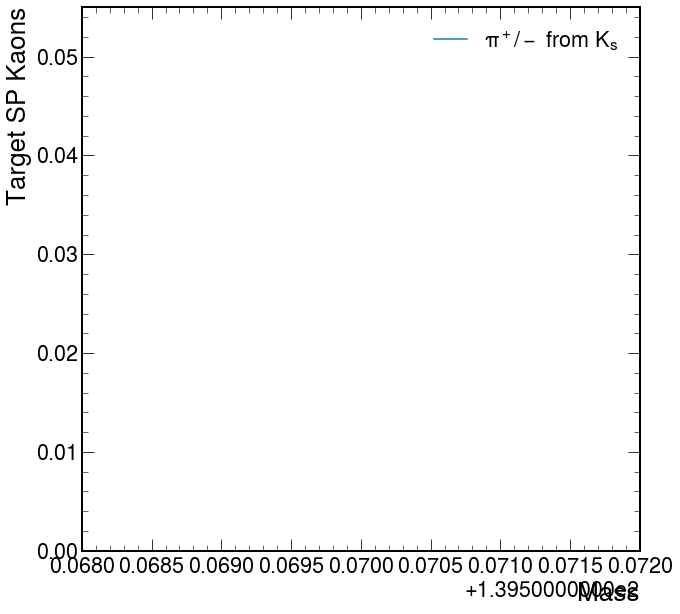

In [7]:
print(hists["Target_mass_hist"])
fig, ax = plt.subplots()
hist.plot1d(hists["Target_mass_hist"],ax=ax,clear=False);
leg = ax.legend([r'$\pi ^+/-$ from $K_s$'])

